In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
from tqdm import tqdm # progress bar for loops, interrupt if needed
from scipy.optimize import curve_fit
from labellines import *
from matplotlib.colors import LinearSegmentedColormap
#Formatting for plots


divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
    
    
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 20.
nbins = 64
mmax = 10
nmax = 10
noise=0.5
"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

Position Angles: 100%|██████████| 9/9 [02:35<00:00, 17.28s/it]
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_19394/893316789.py:70: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  P2 = np.sum(np.sqrt(coscoefs[0,n,2]**2 + sincoefs[0,n,2]**2) for n in (0,1))


IndexError: index 1 is out of bounds for axis 1 with size 1

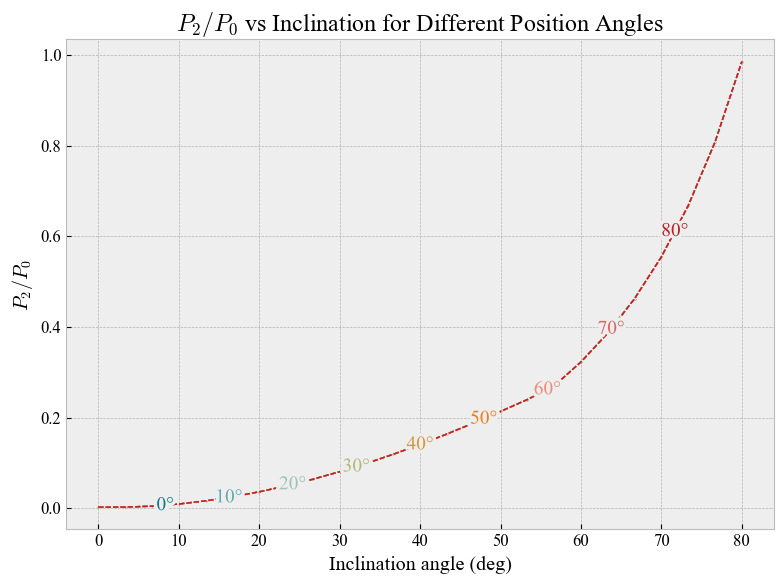

In [9]:
# Parameters
inclinations = np.linspace(0, 80, 25)
position_angles = np.arange(0, 81, 10)
colorindx = np.linspace(0, 1, len(position_angles))
mmax, nmax = 7, 2
noise = 0.5

# Store result
pa_results = {PA: [] for PA in position_angles}

for PA in tqdm(position_angles, desc="Position Angles"):
    for inc in inclinations:
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

        E = D.make_pointexpansion(mmax, nmax, a*1.5)

        # Compute fractional powers
        coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
        m_power = np.sum(coef_mag, axis=1)
        n_power = np.sum(coef_mag, axis=0)
     
        
        # Store P2/P0
        try:
            mratio = m_power[2] / m_power[0]
        except ZeroDivisionError:
            mratio = np.nan
        pa_results[PA].append(mratio)


plt.figure(figsize=(8, 6))

i = 0
for PA, ratios in pa_results.items():
    plt.plot(inclinations, ratios, marker='.', markersize=0.1, linewidth=1,linestyle='dashed', label=f'{PA:.0f}°', color=my_gradient(colorindx[i]))
    i += 1
    

plt.xlabel("Inclination angle (deg)")
plt.ylabel(r"$P_2/ P_0$")
plt.title(r"$P_2/ P_0$ vs Inclination for Different Position Angles")
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.grid(True)
plt.tight_layout()


import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from matplotlib.colors import LinearSegmentedColormap


npy_files=glob.glob('data/*')

inclinations = []
ratios = []

for file in npy_files:
   
    data = np.load(file, allow_pickle=True)[()]
    coscoefs = data['coscoefs']
    sincoefs = data['sincoefs']
    if coscoefs.shape[2] <= 2:
        print(f"Skipping file {file} due to insufficient coefficients.")
    else:
        P0 = np.sqrt(coscoefs[0,0,0]**2 + sincoefs[0,0,0]**2)
        P2 = np.sum(np.sqrt(coscoefs[0,n,2]**2 + sincoefs[0,n,2]**2) for n in (0,1))
        ratio = P2 / P0
        
    

    # Inclination in degrees
    inclination_deg = data['inclination'][0] * 180 / np.pi
   
    
    # Store
    inclinations.append(inclination_deg)
    ratios.append(ratio)


#plot
inclinations = np.array(inclinations)
ratios = np.array(ratios)


#uncomment for real galaxy points
#plt.plot(inclinations, ratios, '.', color='black', markersize=6, label='Points')

plt.xlabel("Inclination (degrees)")
plt.ylabel(r"$P_2/P_0$")
plt.title(rf" $P_2/P_0$ vs Inclination, nmax={nmax-1}")

plt.grid(True)
plt.tight_layout()

"""Blind Test"""
theta = np.random.uniform(40, 80)  # blind test inclination
PA = 0     # blind test PA

D = DiscGalaxy(N=N, a=a)
D.rotate_disc(theta, PA, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

E = D.make_pointexpansion(mmax, 2, a*1.5)

# Compute  powers
coefs = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
m= np.sum(coefs, axis=1)
n = np.sum(coefs, axis=0)

plt.axhline(y=m[2]/m[0],  linestyle='-', color='olive',  label='Blind Test Point')

print("Incl=",theta,"PA=",PA)

plt.show()





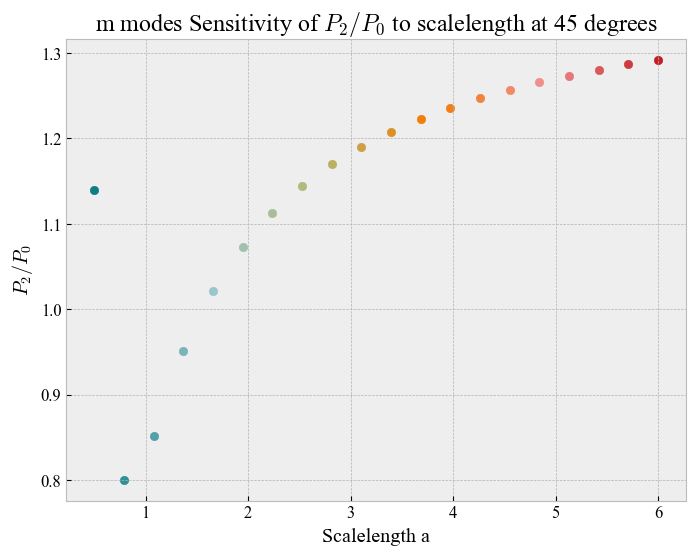

In [4]:
scalelengths = np.linspace(0.5 , 6, 20)

results = []
    
ratios = []

# Store results
counter = 0
colorindx = np.linspace(0, 1, len(scalelengths))
plt.figure(figsize=(8, 6))
for a in scalelengths:
    inclinations = 45
    
   
    D = DiscGalaxy(N=N, a=1)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    #D.generate_image(rmax=8.,nbins=512,noiselevel=0.5)

    E = D.make_pointexpansion(mmax, 2, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)

    fracm_power = m_power
    fracn_power = n_power
    
    results.append({
        "inclination": inc,
        "fracn_power": fracn_power,
        "fracm_power": fracm_power,
        "m_power": m_power,
        "n_power": n_power
    })
    Pm0 = np.array([r["fracm_power"][0] for r in results])
    Pm2 = np.array([r["fracm_power"][2] for r in results])
    ratio = Pm2 / Pm0    
    ratios.append(ratio)
        
    plt.scatter(a,ratio, marker='o',  label=f'{a:.2f}', color=my_gradient(colorindx[counter]), )
    counter += 1
    results = []
    
    ratios = []
    
plt.xlabel("Scalelength a")
plt.ylabel(r"$P_2/P_0$")

labelLines(plt.gca().get_lines(),align=False,fontsize=9)
plt.title(r"m modes Sensitivity of $P_2/P_0$ to scalelength at 45 degrees")
plt.grid(True)


<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_19394/46794690.py:70: SyntaxWarning: invalid escape sequence '\s'
  """ def model(theta_deg, A, B, C):
Position Angles:  18%|█▊        | 8/45 [07:34<34:59, 56.75s/it]
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_19394/46794690.py:70: SyntaxWarning: invalid escape sequence '\s'
  """ def model(theta_deg, A, B, C):


KeyboardInterrupt: 

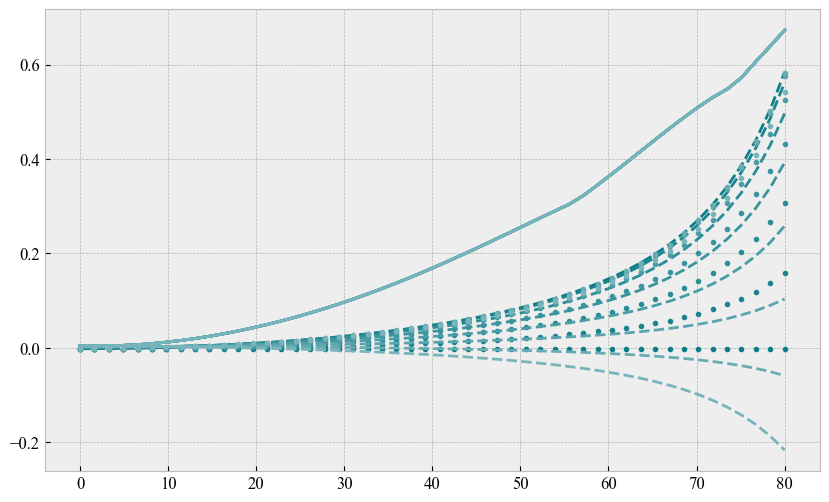

In [11]:
mmax , nmax= 6,6
inclinations = np.linspace(0, 80, 50)
cos = []
position_angles = np.arange(0, 360, 8)

colorindx = np.linspace(0, 1, len(position_angles))
counter = 0
fig, ax = plt.subplots(figsize=(10, 6))
for PA in tqdm(position_angles, desc="Position Angles"):
    eta_list = []
    eta_cos_list = []
    eta_sin_list = []

    for inc in inclinations:
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a*1.5)

        costheta = np.cos(np.radians(inc))
        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        # Compute sums
        num_cos = sum((coscoefs[2, n]) for n in range(nmax))
        num_sin = sum((sincoefs[2, n]) for n in range(nmax))
        num = sum(np.sqrt(coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax))
        denom = sum(np.sqrt(coscoefs[0, n]**2) for n in range(nmax))

        # Avoid divide-by-zero
        eta = num / denom if denom != 0 else np.nan
        eta_cos = num_cos / denom if denom != 0 else np.nan
        eta_sin = num_sin / denom if denom != 0 else np.nan

        # Append to lists
        eta_list.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)
        cos.append(1 - np.sqrt(costheta))

    # Plot after each PA
    plt.plot(inclinations, eta_sin_list, '.', label=rf'{PA}', color=my_gradient(colorindx[counter]))
    plt.plot(inclinations, eta_list, label=rf'$\eta {PA}$', color=my_gradient(colorindx[counter]))
    plt.plot(inclinations, eta_cos_list, '--', label=rf'{PA}', color=my_gradient(colorindx[counter]))
    counter += 1

plt.xlabel("Inclination (deg)")
plt.ylabel(r"$\eta$ components")
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalization and scalar mappable for colorbar
norm = mcolors.Normalize(vmin=min(position_angles), vmax=max(position_angles))
sm = cm.ScalarMappable(cmap=my_gradient, norm=norm)
sm.set_array([])  # required for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Position Angle (deg)')
plt.title(r"Variation of $\eta$, $\eta_{\cos}$, $\eta_{\sin}$ vs Inclination")
plt.grid(True)

plt.tight_layout()
plt.show()



"""Best fit for eta curve:"""



""" def model(theta_deg, A, B, C):
    theta_rad = np.radians(theta_deg)
    return 1-A * np.cos(theta_rad)**B + C

popt, pcov = curve_fit(model, inclinations, eta_list, p0=[1.0, 1.0, 0.01])
A_fit, B_fit, C_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 80, 500)
Rm_fit = model(theta_fit, *popt)


# Compute RMSE
Rmse_pred = model(inclinations, *popt)



#plt.plot(inclinations,cos, label=r'$1-\sqrt{\cos(\theta)}$', color='#99c6cc')
#plt.plot(theta_fit, Rm_fit, '--', label=rf'Fit:1- {A_fit:.2f}$\cos(\theta)$^{B_fit:.2f} + {C_fit:.2f}', color='#ee9093')
plt.title(r"$\eta$ vs Inclination")
plt.xlabel("Inclination angle (deg)")
plt.ylabel(r"$\eta$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
 """

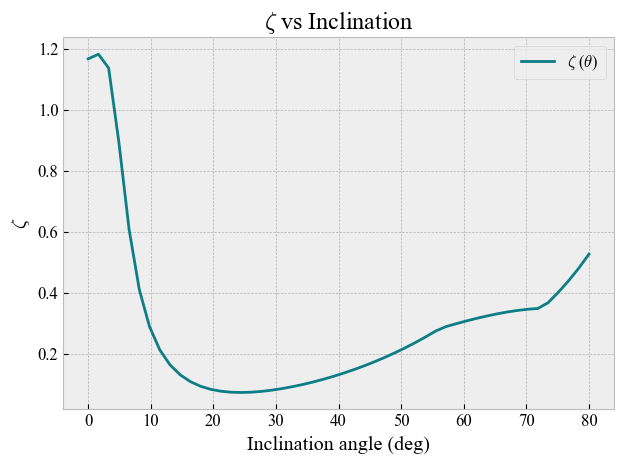

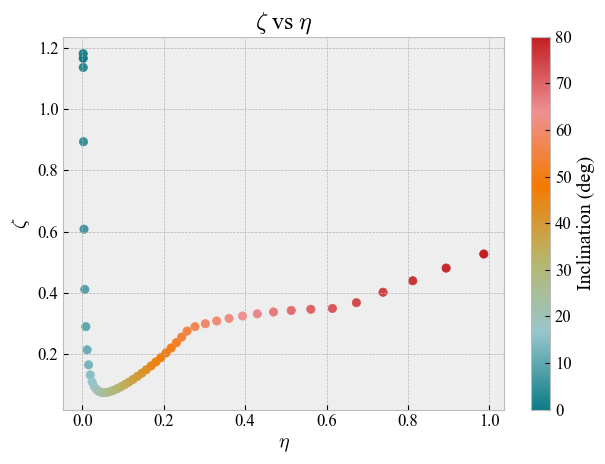

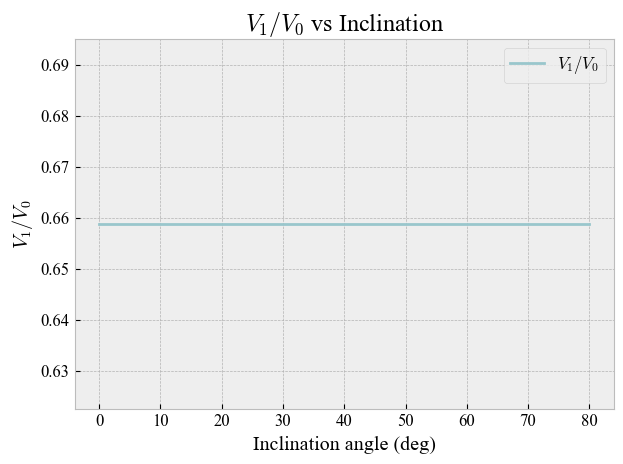

In [7]:
zeta_list = []
for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    E = D.make_pointexpansion(mmax, nmax, a*1.5)
    
    coscoefs = E.coscoefs
    sincoefs = E.sincoefs
    num = sum(np.sqrt(coscoefs[4, n]**2 + sincoefs[4, n]**2) for n in range(nmax))
    denom = sum(np.sqrt(coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax))

    zeta = num / denom if denom != 0 else np.nan
    zeta_list.append(zeta)
    
plt.plot(inclinations, zeta_list, label=r'$\zeta$ ($\theta$)', color='#0d7d87')

plt.title(r"$\zeta$ vs Inclination")
plt.xlabel("Inclination angle (deg)")
plt.ylabel(r"$\zeta$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  

plt.scatter(eta_list, zeta_list, c=inclinations, cmap=my_gradient)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\zeta$")
plt.colorbar(label="Inclination (deg)")
plt.title(r"$\zeta$ vs $\eta$")
plt.grid(True)
plt.tight_layout()
plt.show()

ratios_01 = []
for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    E = D.make_pointexpansion(mmax, nmax, a*1.5)
        
    c00 = coscoefs[0,0]
    c01 = coscoefs[0,1]
    ratio = np.sqrt(c01**2) / np.sqrt(c00**2) if c00 != 0 else np.nan
    ratios_01.append(ratio)




plt.plot(inclinations, ratios_01, label=r"$V_1/V_0$", color='#99c6cc')
plt.title(r"$V_1/V_0$ vs Inclination")
plt.xlabel("Inclination angle (deg)")
plt.ylabel(r"$V_1/V_0$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

data/flux_expansion_data_8084-9102.npy
data/flux_expansion_data_7960-12704.npy
data/flux_expansion_data_8077-12704.npy
data/flux_expansion_data_12070-3701.npy
data/flux_expansion_data_7960-6101.npy
data/flux_expansion_data_8085-12704.npy
data/flux_expansion_data_12074-12705.npy
data/flux_expansion_data_12074-12704.npy
data/flux_expansion_data_8077-1902.npy
data/flux_expansion_data_8077-6102.npy
data/flux_expansion_data_12070-6103.npy
data/flux_expansion_data_12074-12703.npy
data/flux_expansion_data_8079-12702.npy
data/flux_expansion_data_8084-6101.npy
data/flux_expansion_data_12078-9101.npy
data/flux_expansion_data_8079-12701.npy
data/flux_expansion_data_12074-9102.npy
data/flux_expansion_data_8082-12701.npy
data/flux_expansion_data_8084-12702.npy
data/flux_expansion_data_8078-9101.npy


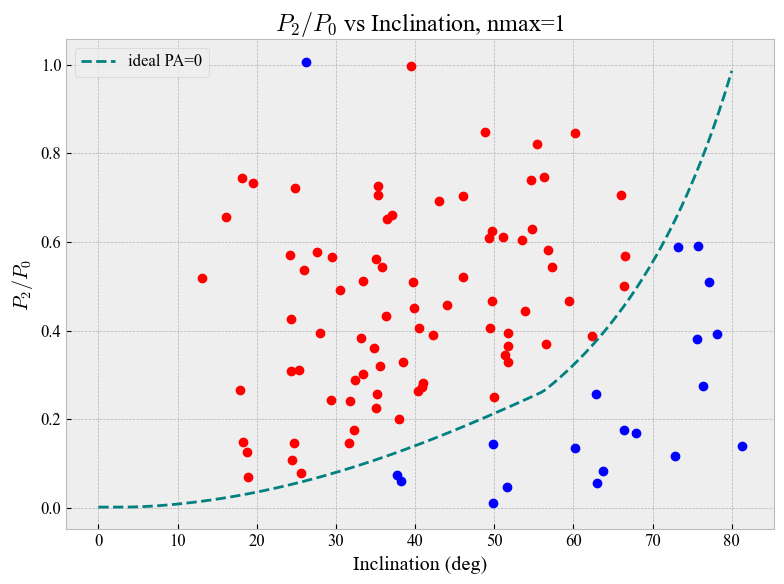

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt

# 1) Recompute the “dashed” theoretical curve at high resolution
incl_theo = np.linspace(0, 80, 200)
ratio_theo = []
for inc in incl_theo:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0)   # no noise
    E = D.make_pointexpansion(mmax, nmax, a*1.5)
    mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_pow = mag.sum(axis=1)
    ratio_theo.append(m_pow[2]/m_pow[0])

ratio_theo = np.array(ratio_theo)

# 2) Now read your real .npy files and classify against the interpolated threshold
npy_files = glob.glob('data/*.npy')

plt.figure(figsize=(8,6))
for fn in npy_files:
    data = np.load(fn, allow_pickle=True)[()]
    coscoefs = data['coscoefs']
    sincoefs = data['sincoefs']
    # skip bad files...
    P0 = np.sqrt(coscoefs[0,0,0]**2 + sincoefs[0,0,0]**2)
    P2 = np.sqrt(coscoefs[0,0,2]**2 + sincoefs[0,0,2]**2)
    ratio = P2/P0
    inc_deg = data['inclination'][0]*180/np.pi
    
    # interpolate the theoretical curve to get the exact threshold at this inclination
    thresh = np.interp(inc_deg, incl_theo, ratio_theo)
    
    if ratio < thresh or ratio > 1:
        print(f"{fn}")
        plt.plot(inc_deg, ratio, 'o', color='blue')
    else:
        plt.plot(inc_deg, ratio, 'o', color='red')

# 3) re‐draw your dashed line on top
plt.plot(incl_theo, ratio_theo, '--', color='teal', label='ideal PA=0')
plt.xlabel("Inclination (deg)")
plt.ylabel(r"$P_2/P_0$")
plt.title(f"$P_2/P_0$ vs Inclination, nmax={nmax-1}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Position Angles: 100%|██████████| 5/5 [02:29<00:00, 29.85s/it]


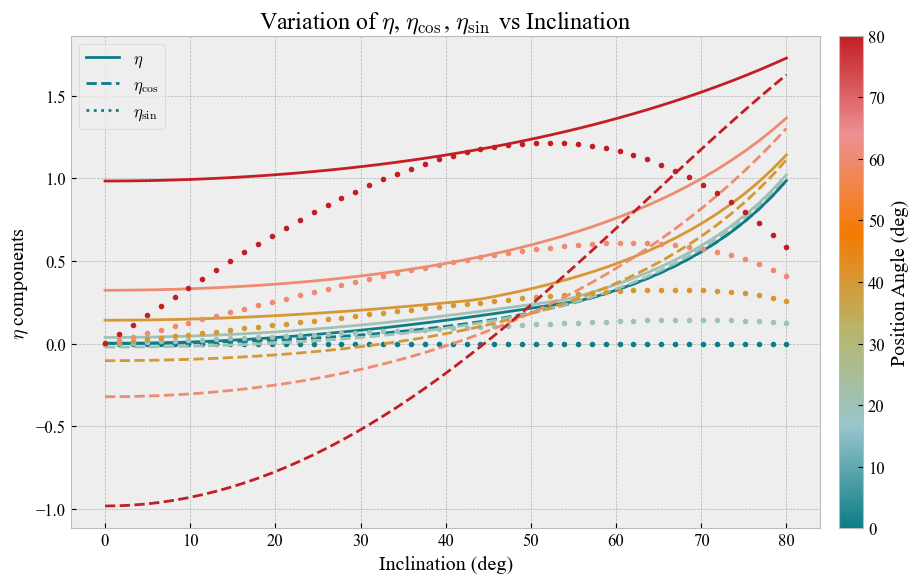

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

mmax, nmax = 6,2
inclinations   = np.linspace(0, 80, 50)
position_angles= np.arange(0, 81, 20)
colorindx      = np.linspace(0, 1, len(position_angles))

fig, ax = plt.subplots(figsize=(10, 6))

counter = 0
for PA in tqdm(position_angles, desc="Position Angles"):
    eta_list = []
    eta_cos_list = []
    eta_sin_list = []
    for inc in inclinations:
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(inc, PA, 0)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a*1.5)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        num_cos = sum(coscoefs[2, n] for n in range(nmax))
        num_sin = sum(sincoefs[2, n] for n in range(nmax))
        num     = sum(np.hypot(coscoefs[2, n], sincoefs[2, n]) for n in range(nmax))
        denom   = sum(abs(coscoefs[0, n])           for n in range(nmax))

        eta      = num     / denom if denom else np.nan
        eta_cos  = num_cos / denom if denom else np.nan
        eta_sin  = num_sin / denom if denom else np.nan

        eta_list.append(    eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    col = my_gradient(colorindx[counter])
    # plot *without* labels so nothing shows up in the legend
    ax.plot(inclinations, eta_list,     color=col, linestyle='-')
    ax.plot(inclinations, eta_cos_list, color=col, linestyle='--')
    ax.plot(inclinations, eta_sin_list, color=col, marker='.', linestyle='none')
    counter += 1

# colour‐bar for PA
import matplotlib.cm as cm, matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=position_angles.min(), vmax=position_angles.max())
sm = cm.ScalarMappable(cmap=my_gradient, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Position Angle (deg)')

# now add a legend for linestyle only, via proxy artists
proxies = [
    Line2D([0],[0], color=my_gradient(0), linestyle='-',  label=r'$\eta$'),
    Line2D([0],[0], color=my_gradient(0), linestyle='--', label=r'$\eta_{\cos}$'),
    Line2D([0],[0], color=my_gradient(0), linestyle='dotted', label=r'$\eta_{\sin}$'),
]
ax.legend(handles=proxies, loc='upper left')

ax.set_xlabel("Inclination (deg)")
ax.set_ylabel(r"$\eta$ components")
ax.set_title(r"Variation of $\eta$, $\eta_{\cos}$, $\eta_{\sin}$ vs Inclination")
ax.grid(True)
plt.tight_layout()
plt.show()


<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:46: SyntaxWarning: invalid escape sequence '\e'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_14986/2066710031.py:46: SyntaxWarning: invalid escape sequence '\e'
  ax[axi].set_title(f"$\eta$ vs $\\eta_{{{comp}}}$")


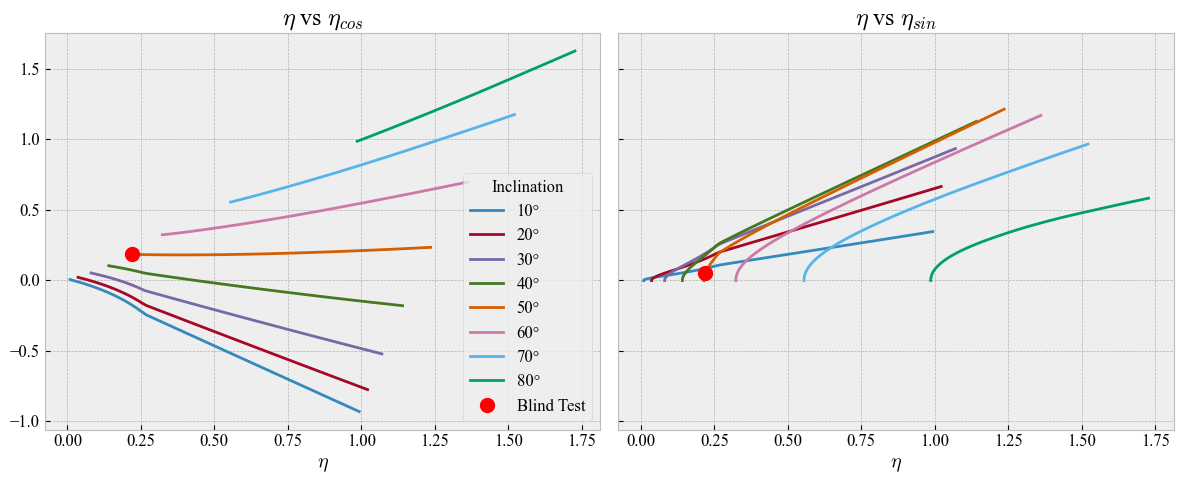

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# parameters
mmax, nmax = 6, 2

# the grid of inclinations to draw curves for:
incl_list = np.linspace(10, 80, 8)     # eight sample inclinations
PA_list   = np.linspace(0, 80, 41)     # fine PA sampling
colorindx = np.linspace(0, 1, len(PA_list))
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
i=0

for axi, comp in enumerate(['cos','sin']):
   
    for inc in incl_list:
        etas      = []
        eta_comps = []
        for PA in PA_list:
            # generate the galaxy
            D = DiscGalaxy(N=N, a=a)
            D.rotate_disc(inc, PA, 0)
            D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
            E = D.make_pointexpansion(mmax, nmax, a*1.5)

            c = E.coscoefs; s = E.sincoefs

            num_cos = sum(c[2,n] for n in range(nmax))
            num_sin = sum(s[2,n] for n in range(nmax))
            num     = sum(np.hypot(c[2,n], s[2,n]) for n in range(nmax))
            den     = sum(abs(c[0,n])            for n in range(nmax))

            eta     = num/den if den else np.nan
            eta_cos  = num_cos/den if den else np.nan
            eta_sin  = num_sin/den if den else np.nan

            etas.append(eta)
            eta_comps.append(eta_cos if comp=='cos' else eta_sin)

        # plot one curve (inc fixed, PA varying)
        ax[axi].plot(etas, eta_comps, '-', label=f"{inc:.0f}°")
        i += 1
        
    ax[axi].set_xlabel(r"$\eta$")
    ax[axi].set_title(f"$\eta$ vs $\\eta_{{{comp}}}$")
    ax[axi].grid(True)

# now do the blind test and overplot a big marker
theta_bt =  50  # whatever your blind‐test incl in deg
PA_bt    = 10      # your blind‐test PA in deg

D = DiscGalaxy(N=N, a=a)
D.rotate_disc(theta_bt, PA_bt, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
E = D.make_pointexpansion(mmax, nmax, a*1.5)

c = E.coscoefs; s = E.sincoefs
num_cos = sum(c[2,n] for n in range(nmax))
num_sin = sum(s[2,n] for n in range(nmax))
num     = sum(np.hypot(c[2,n], s[2,n]) for n in range(nmax))
den     = sum(abs(c[0,n])            for n in range(nmax))

eta_bt     = num/den
eta_cos_bt = num_cos/den
eta_sin_bt = num_sin/den

# big red dot
ax[0].plot(eta_bt, eta_cos_bt, 'o', color='red', markersize=10, label="Blind Test")
ax[1].plot(eta_bt, eta_sin_bt, 'o', color='red', markersize=10)

# legends
ax[0].legend(title="Inclination")
plt.tight_layout()
plt.show()


In [ ]:
D = DiscGalaxy(N=N, a=a)
inc=80 # change to see how coefficients change

PA=0
mmax,nmax=10,10
D.rotate_disc(inc, PA, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
E = D.make_pointexpansion(mmax, nmax, a*1.5)

coscoefs = E.coscoefs
sincoefs = E.sincoefs

Amn = np.sqrt(E.coscoefs**2 + E.sincoefs**2) 

Amn_matrix = Amn.T 

# Print matrix
print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,3)) 




Amn (rows = n, columns = m):
[[0.036 0.    0.042 0.    0.025 0.    0.016 0.    0.01  0.    0.006]
 [0.024 0.    0.017 0.    0.006 0.    0.001 0.    0.001 0.    0.001]
 [0.016 0.    0.005 0.    0.001 0.    0.003 0.    0.002 0.    0.002]
 [0.012 0.    0.    0.    0.003 0.    0.003 0.    0.002 0.    0.001]
 [0.009 0.    0.002 0.    0.003 0.    0.002 0.    0.001 0.    0.   ]
 [0.006 0.    0.003 0.    0.002 0.    0.001 0.    0.    0.    0.   ]
 [0.005 0.    0.003 0.    0.002 0.    0.001 0.    0.    0.    0.   ]
 [0.004 0.    0.003 0.    0.001 0.    0.    0.    0.    0.    0.   ]
 [0.003 0.    0.002 0.    0.001 0.    0.    0.    0.    0.    0.   ]
 [0.002 0.    0.002 0.    0.001 0.    0.    0.    0.    0.    0.   ]]
